In [13]:
from lstm_module import LSTM_SS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [17]:
df = pd.read_csv('C:/Users/shail/Desktop/standarddataset/Alcohol_Sales.csv', parse_dates=True)
df['Month']= pd.to_datetime(df['Month'])
df['Month']= df['Month'].dt.strftime('%Y-%d-%m')
df['Month']= pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
#df.index.freq='MS'

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   325 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [19]:
df.head()

,Sales
Month,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [20]:
train = df.iloc[:300]
test = df.iloc[300:]

scaler = MinMaxScaler()

In [21]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

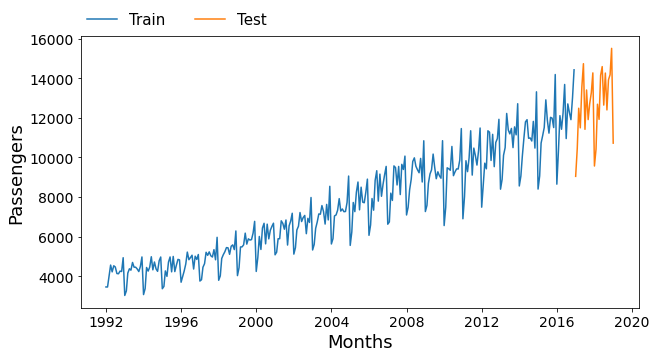

In [22]:
plt.figure(figsize=(10, 5))

plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')

plt.xlabel('Months', fontsize=18)
plt.ylabel('Passengers', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
           borderaxespad=0, frameon=False, prop={"size":15})

plt.show()


In [23]:
n_input = 12
n_features = 1

def generate_data(data, n_input):
    X, y = [], []
    for i in range(0,len(data)-n_input):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input])
    return np.array(X), np.array(y)

X, y = generate_data(scaled_train, n_input)

# Original LSTM

In [24]:
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X, y, epochs=50, verbose=0)

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.7540311], dtype=float32),
 array([0.7817627], dtype=float32),
 array([0.7991508], dtype=float32),
 array([0.79976714], dtype=float32),
 array([0.8112284], dtype=float32),
 array([0.81512874], dtype=float32),
 array([0.80042505], dtype=float32),
 array([0.8182815], dtype=float32),
 array([0.8170519], dtype=float32),
 array([0.81994313], dtype=float32),
 array([0.827319], dtype=float32),
 array([0.8210809], dtype=float32),
 array([0.7935987], dtype=float32),
 array([0.79783785], dtype=float32),
 array([0.8004763], dtype=float32),
 array([0.80184776], dtype=float32),
 array([0.8037394], dtype=float32),
 array([0.80432373], dtype=float32),
 array([0.80423987], dtype=float32),
 array([0.8060973], dtype=float32),
 array([0.8053792], dtype=float32),
 array([0.804343], dtype=float32),
 array([0.8024425], dtype=float32),
 array([0.79894656], dtype=float32),
 array([0.7957561], dtype=float32)]

In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

test['original_LSTM'] = true_predictions

<AxesSubplot:xlabel='Month'>

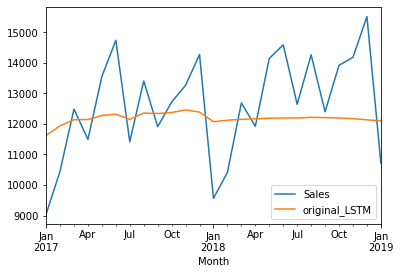

In [28]:
test.plot()

In [29]:
rmse = sqrt(mean_squared_error(test['Sales'], test['original_LSTM']))
print(rmse)

1633.2846308125986


In [30]:
test

,Sales,original_LSTM
Month,,
2017-01-01,9043,11619.414477
2017-02-01,10452,11935.277371
2017-03-01,12481,12133.327892
2017-04-01,11491,12140.347686
2017-05-01,13545,12270.891413
2017-06-01,14730,12315.316390
2017-07-01,11416,12147.841350
2017-08-01,13402,12351.225963
2017-09-01,11907,12337.220999


# SELF_MADE_LSTM

In [31]:
self_model = LSTM_SS(1, 1, 200, n_input, 0.01)

In [32]:
self_model.fit(50, X, y, verbose=False)

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = self_model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.90643096]),
 array([0.97728002]),
 array([0.84189731]),
 array([0.90568146]),
 array([1.01014704]),
 array([0.91918478]),
 array([1.00404504]),
 array([1.00200097]),
 array([1.01161505]),
 array([1.06588721]),
 array([1.00055831]),
 array([1.0677665]),
 array([1.03092975]),
 array([1.05073191]),
 array([1.08780299]),
 array([0.98369384]),
 array([1.06238038]),
 array([1.0085691]),
 array([0.9928152]),
 array([0.99015481]),
 array([0.91169632]),
 array([0.98010237]),
 array([0.90938914]),
 array([0.91450359]),
 array([0.90562995])]

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

test['SELF_MADE_LSTM'] = true_predictions

<AxesSubplot:xlabel='Month'>

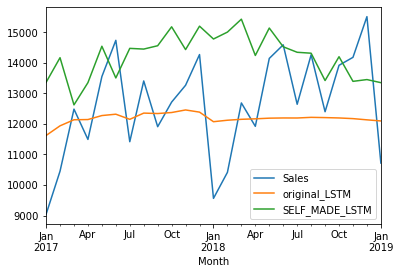

In [35]:
test.plot()

In [36]:
rmse = sqrt(mean_squared_error(test['Sales'], test['SELF_MADE_LSTM']))
print(rmse)

2381.211897035946


In [37]:
test

,Sales,original_LSTM,SELF_MADE_LSTM
Month,,,
2017-01-01,9043,11619.414477,13355.248643
2017-02-01,10452,11935.277371,14162.219371
2017-03-01,12481,12133.327892,12620.210330
2017-04-01,11491,12140.347686,13346.711803
2017-05-01,13545,12270.891413,14536.574784
2017-06-01,14730,12315.316390,13500.514683
2017-07-01,11416,12147.841350,14467.073053
2017-08-01,13402,12351.225963,14443.791023
2017-09-01,11907,12337.220999,14553.295427
